# Deep Metric Learning 
## Dataset: LFW


In [ ]:
!pip install tensorflow_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 207 kB 30.5 MB/s 
     |████████████████████████████████| 88 kB 9.5 MB/s 
     |████████████████████████████████| 13.4 MB 70.0 MB/s 
     |████████████████████████████████| 188 kB 55.4 MB/s 
     |████████████████████████████████| 1.1 MB 65.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=35a5a495845e3b14cad6436acd60d14e98f60f21c14b3ae301e060913b440c2b
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=0de3e5ccb4daaa958b2214b9f460cb2003871176db5b76733626ead6f0700e47
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


Importing Libraries:

In [ ]:
import pandas as pd
import numpy as np
import random
import time
from keras.models import load_model
import tensorflow_similarity as tfsim
from tensorflow import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow_similarity.samplers import MultiShotMemorySampler
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation, Conv2D, MaxPooling2D  , Softmax, BatchNormalization, LayerNormalization , Add, Flatten
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.losses import TripletLoss
from tensorflow.keras.optimizers import Adam
import umap
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive')

## Preproccessing

Importing LFW and dividing it into the test and train datasets:

In [ ]:
lfw_subset = fetch_lfw_people(min_faces_per_person=75, resize=None,color=True, slice_=None)

Making train and test datasets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lfw_subset.images , lfw_subset.target,test_size=0.20, random_state=0)
#Normalizing input pictures:
X_train_n = X_train/255
X_test_n = X_test/255

Plot a sample of these 6 calsses:

Text(0.5, 1.0, 'Tony Blair (Label:5)')

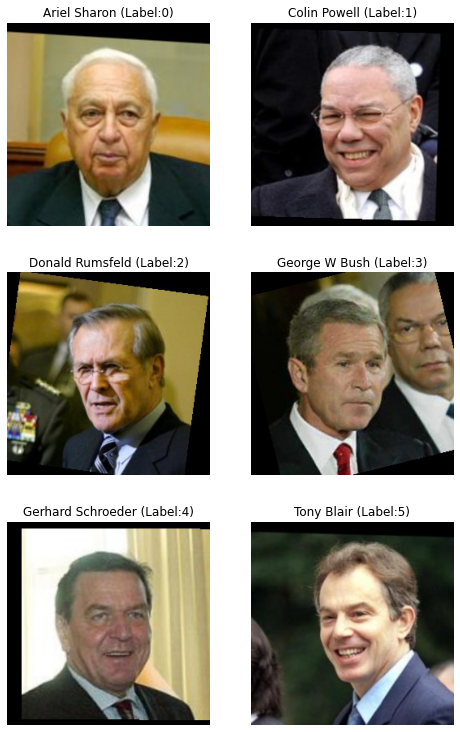

In [ ]:
fig = plt.figure(figsize=(8, 13))
fig.add_subplot(3, 2, 1)
plt.imshow(lfw_subset.images[np.where(lfw_subset.target==0)[0][0]])
plt.axis('off')
plt.title(lfw_subset.target_names[0]+' (Label:0)')
fig.add_subplot(3, 2, 2)
plt.imshow(lfw_subset.images[np.where(lfw_subset.target==1)[0][0]])
plt.axis('off')
plt.title(lfw_subset.target_names[1]+' (Label:1)')
fig.add_subplot(3, 2, 3)
plt.imshow(lfw_subset.images[np.where(lfw_subset.target==2)[0][0]])
plt.axis('off')
plt.title(lfw_subset.target_names[2]+' (Label:2)')
fig.add_subplot(3, 2, 4)
plt.imshow(lfw_subset.images[np.where(lfw_subset.target==3)[0][0]])
plt.axis('off')
plt.title(lfw_subset.target_names[3]+' (Label:3)')
fig.add_subplot(3, 2, 5)
plt.imshow(lfw_subset.images[np.where(lfw_subset.target==4)[0][0]])
plt.axis('off')
plt.title(lfw_subset.target_names[4]+' (Label:4)')
fig.add_subplot(3, 2, 6)
plt.imshow(lfw_subset.images[np.where(lfw_subset.target==5)[0][0]])
plt.axis('off')
plt.title(lfw_subset.target_names[5]+' (Label:5)')


## Training:

Creating a sampler object  to train the model efectively:

considering 16 examples from all of the 6 classes in every batch.

In [ ]:
random.seed(0)
CLASSES = random.sample(population=range(len(lfw_subset.target_names)), k=len(lfw_subset.target_names))
NUM_CLASSES = 6  
CLASS_PER_BATCH = NUM_CLASSES
EXAMPLE_PER_CLASS = 16 

train_sampler = MultiShotMemorySampler(X_train_n, y_train, classes_per_batch=CLASS_PER_BATCH, examples_per_class_per_batch=EXAMPLE_PER_CLASS,class_list=CLASSES)


The initial batch size is 96 (6 classes * 16 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/973 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/6 [00:00<?, ?it/s]

gather examples:   0%|          | 0/973 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/973 [00:00<?, ?it/s]

Define the model architecture:

In [ ]:
def Model_generator(input_shape):
  inputs = layers.Input(shape =input_shape , name='InputTensor')

  x = inputs 
  x = keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=input_shape)(x)
  #x = MaxPooling2D(pool_size=2, name='pool_conv1')(x) 
  # Fully Connected Layer:
  x = Flatten(name='Flat')(x)
  outputs =  Dense(100,name='Fully_Connected')(x) 
  return SimilarityModel(inputs, outputs)

### Considering loss(with cosine distance), optimiser and learning rate:

In [ ]:
model = Model_generator(input_shape = (250, 250, 3))
#Defining Loss
distance = 'cosine' #@param ["cosine", "L2", "L1"]{allow-input: false}
Loss = TripletLoss(distance=distance)

opt = Adam(learning_rate=0.00002)
model.compile(optimizer=opt, loss=Loss)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Distance metric automatically set to cosine use the distance arg to override.
Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputTensor (InputLayer)    [(None, 250, 250, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flat (Flatten)              (None, 131072)            0         
                                                                 
 Fully_Connected (Dense)     (None, 100)               13107300  
                                                                 
Total params: 36,695,012
Trainable params: 36,641,892
Non-trainable params: 53,120
_________________________________________________________________


plot the model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


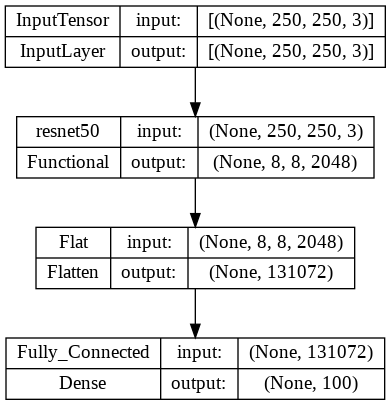

In [ ]:
drive.mount('/content/drive')
keras.utils.plot_model(model, to_file="/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/first_model.png", show_shapes=True)

Train model with cosine similarity base triplet loss :

In [ ]:
EPOCHS = 15
best_save=ModelCheckpoint('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/Cosine',save_best_only=True,monitor='loss',mode='min')
start = time.time()
history = model.fit(train_sampler, epochs=EPOCHS, validation_data=(X_test_n, y_test),callbacks=[best_save])
stop = time.time()
train_time = stop-start
print('training time is :'  ,train_time)

Epoch 1/15
1000/1000 [==============================] - ETA: 0s - loss: 0.0144

1000/1000 [==============================] - 1281s 1s/step - loss: 0.0144 - val_loss: 1.0000
Warmup complete
Epoch 2/15
1000/1000 [==============================] - ETA: 0s - loss: 9.9199e-04

1000/1000 [==============================] - 1246s 1s/step - loss: 9.9199e-04 - val_loss: 0.0451
Epoch 3/15
1000/1000 [==============================] - ETA: 0s - loss: 2.5844e-04

1000/1000 [==============================] - 1243s 1s/step - loss: 2.5844e-04 - val_loss: 0.0205
Epoch 4/15
1000/1000 [==============================] - ETA: 0s - loss: 1.5562e-04

1000/1000 [==============================] - 1241s 1s/step - loss: 1.5562e-04 - val_loss: 0.0205
Epoch 5/15
1000/1000 [==============================] - 1220s 1s/step - loss: 0.0077 - val_loss: 0.0287
Epoch 6/15
1000/1000 [==============================] - ETA: 0s - loss: 1.4768e-04

1000/1000 [==============================] - 1243s 1s/step - loss: 1.4768e-04 - val_loss: 0.0205
Epoch 7/15
1000/1000 [==============================] - 1219s 1s/step - loss: 6.2936e-04 - val_loss: 0.0246
Epoch 8/15
1000/1000 [==============================] - ETA: 0s - loss: 8.6110e-05

1000/1000 [==============================] - 1243s 1s/step - loss: 8.6110e-05 - val_loss: 0.0205
Epoch 9/15
1000/1000 [==============================] - 1225s 1s/step - loss: 5.8813e-04 - val_loss: 0.0287
Epoch 10/15
1000/1000 [==============================] - ETA: 0s - loss: 4.5151e-05

1000/1000 [==============================] - 1245s 1s/step - loss: 4.5151e-05 - val_loss: 0.0164
Epoch 11/15
1000/1000 [==============================] - 1223s 1s/step - loss: 8.1053e-04 - val_loss: 0.0123
Epoch 12/15
1000/1000 [==============================] - 1223s 1s/step - loss: 9.1266e-04 - val_loss: 0.0164
Epoch 13/15
1000/1000 [==============================] - ETA: 0s - loss: 3.2799e-05

1000/1000 [==============================] - 1245s 1s/step - loss: 3.2799e-05 - val_loss: 0.0246
Epoch 14/15
1000/1000 [==============================] - 1226s 1s/step - loss: 5.1210e-04 - val_loss: 0.0287
Epoch 15/15
1000/1000 [==============================] - 1228s 1s/step - loss: 4.9014e-04 - val_loss: 0.0123
training time is : 18668.49441576004


In [ ]:
drive.mount('/content/drive')
np.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/Cosine'+'/loss.npy',history.history['loss'])
np.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/Cosine'+'/val_loss.npy',history.history['val_loss'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot loss during the training:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


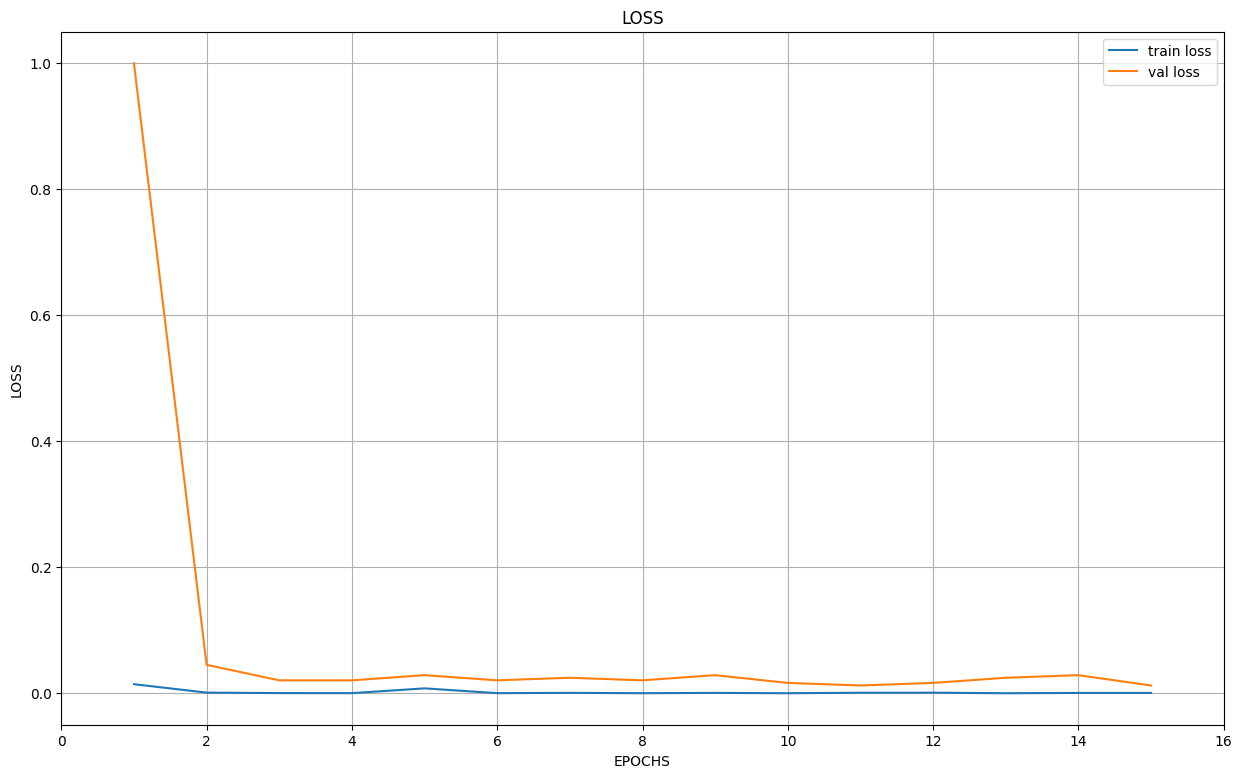

In [ ]:
drive.mount('/content/drive')
import matplotlib
matplotlib.style.use('default')
loss=history.history['loss']
val_loss=history.history['val_loss']

EPOCH= range(1,15+1)

plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,loss)
plt.plot(EPOCH,val_loss)
plt.title('LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.grid()
plt.xlim([0,15+1])
plt.legend(['train loss','val loss'])
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/Cosine_Loss.jpg')
plt.show()



#### Embedding (Model with Cosine Similarity) for training dataset:

Load model:

In [ ]:
drive.mount('/content/drive')
model.load_weights('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/Cosine')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ploting embedding:

In [ ]:
NClass_Mem = np.zeros(5,dtype='int') # an array to save number of every classe in the train dataset
for i in range(len(y_train)):
  if y_train[i]==0 :
    NClass_Mem[0]=NClass_Mem[0]+1
  if y_train[i]==1 :
    NClass_Mem[1]=NClass_Mem[1]+1
  if y_train[i]==2 :
    NClass_Mem[2]=NClass_Mem[2]+1
  if y_train[i]==3 :
    NClass_Mem[3]=NClass_Mem[3]+1
  if y_train[i]==4 :
    NClass_Mem[4]=NClass_Mem[4]+1

Class_0 = np.zeros((NClass_Mem[0],250,250,3))
Class_1 = np.zeros((NClass_Mem[1],250,250,3))
Class_2 = np.zeros((NClass_Mem[2],250,250,3))
Class_3 = np.zeros((NClass_Mem[3],250,250,3))
Class_4 = np.zeros((NClass_Mem[4],250,250,3))

Class_conter = np.zeros(5,dtype='int') 
for i in range(len(y_train)):
  if y_train[i]==0 :
    Class_0[Class_conter[0],:] =X_train_n[i,:] 
    Class_conter[0]=Class_conter[0]+1
  if y_train[i]==1 :
    Class_1[Class_conter[1],:] =X_train_n[i,:] 
    Class_conter[1]=Class_conter[1]+1
  if y_train[i]==2 :
    Class_2[Class_conter[2],:] =X_train_n[i,:] 
    Class_conter[2]=Class_conter[2]+1
  if y_train[i]==3 :
    Class_3[Class_conter[3],:] =X_train_n[i,:] 
    Class_conter[3]=Class_conter[3]+1
  if y_train[i]==4 :
    Class_4[Class_conter[4],:] =X_train_n[i,:] 
    Class_conter[4]=Class_conter[4]+1

Emb_Class_0 = model(Class_0)
Emb_Class_1 = model(Class_1)
Emb_Class_2 = model(Class_2)
Emb_Class_3 = model(Class_3)
Emb_Class_4 = model(Class_4)

In [ ]:
reducer = umap.UMAP(random_state=0)
reduce_embedding_Class_0 = reducer.fit_transform(Emb_Class_0)
reduce_embedding_Class_1 = reducer.fit_transform(Emb_Class_1)
reduce_embedding_Class_2 = reducer.fit_transform(Emb_Class_2)
reduce_embedding_Class_3 = reducer.fit_transform(Emb_Class_3)
reduce_embedding_Class_4 = reducer.fit_transform(Emb_Class_4)

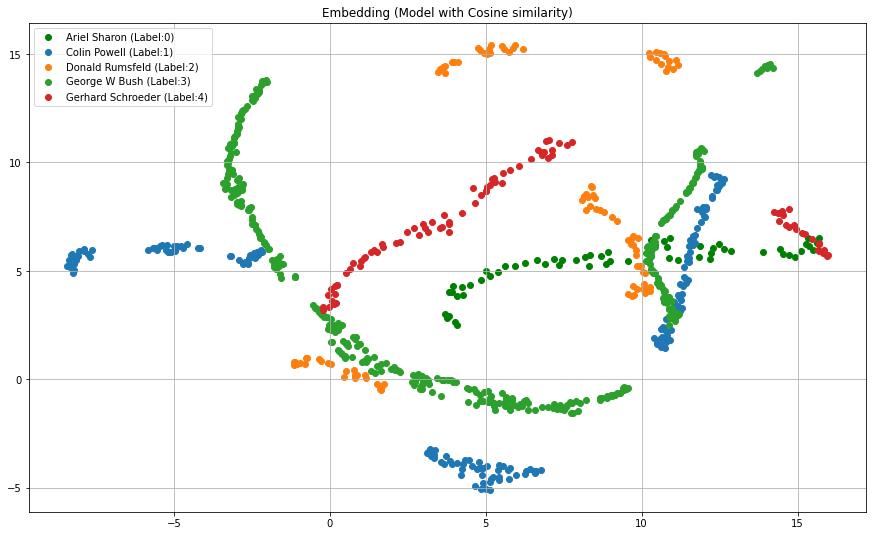

In [ ]:
plt.gcf().set_size_inches(15,9,forward=True)
plt.scatter(reduce_embedding_Class_0[:,0],reduce_embedding_Class_0[:,1],color="g")
plt.scatter(reduce_embedding_Class_1[:,0],reduce_embedding_Class_1[:,1])
plt.scatter(reduce_embedding_Class_2[:,0],reduce_embedding_Class_2[:,1])
plt.scatter(reduce_embedding_Class_3[:,0],reduce_embedding_Class_3[:,1])
plt.scatter(reduce_embedding_Class_4[:,0],reduce_embedding_Class_4[:,1])
plt.grid()
plt.legend([lfw_subset.target_names[0]+' (Label:0)',lfw_subset.target_names[1]+' (Label:1)',lfw_subset.target_names[2]+' (Label:2)',lfw_subset.target_names[3]+' (Label:3)',lfw_subset.target_names[4]+' (Label:4)'])
plt.title('Embedding (Model with Cosine similarity)')
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/cosine_embedding_train.jpg')
plt.show()

#### Embedding (Model with Cosine Similarity) for test dataset:

Ploting embedding:

In [ ]:
NClass_Mem = np.zeros(5,dtype='int') # an array to save number of every classe in the train dataset
for i in range(len(y_test)):
  if y_test[i]==0 :
    NClass_Mem[0]=NClass_Mem[0]+1
  if y_test[i]==1 :
    NClass_Mem[1]=NClass_Mem[1]+1
  if y_test[i]==2 :
    NClass_Mem[2]=NClass_Mem[2]+1
  if y_test[i]==3 :
    NClass_Mem[3]=NClass_Mem[3]+1
  if y_test[i]==4 :
    NClass_Mem[4]=NClass_Mem[4]+1

Class_0 = np.zeros((NClass_Mem[0],250,250,3))
Class_1 = np.zeros((NClass_Mem[1],250,250,3))
Class_2 = np.zeros((NClass_Mem[2],250,250,3))
Class_3 = np.zeros((NClass_Mem[3],250,250,3))
Class_4 = np.zeros((NClass_Mem[4],250,250,3))

Class_conter = np.zeros(5,dtype='int') 
for i in range(len(y_test)):
  if y_test[i]==0 :
    Class_0[Class_conter[0],:] =X_test_n[i,:] 
    Class_conter[0]=Class_conter[0]+1
  if y_test[i]==1 :
    Class_1[Class_conter[1],:] =X_test_n[i,:] 
    Class_conter[1]=Class_conter[1]+1
  if y_test[i]==2 :
    Class_2[Class_conter[2],:] =X_test_n[i,:] 
    Class_conter[2]=Class_conter[2]+1
  if y_test[i]==3 :
    Class_3[Class_conter[3],:] =X_test_n[i,:] 
    Class_conter[3]=Class_conter[3]+1
  if y_test[i]==4 :
    Class_4[Class_conter[4],:] =X_test_n[i,:] 
    Class_conter[4]=Class_conter[4]+1

Emb_Class_0 = model(Class_0)
Emb_Class_1 = model(Class_1)
Emb_Class_2 = model(Class_2)
Emb_Class_3 = model(Class_3)
Emb_Class_4 = model(Class_4)

In [ ]:
reducer = umap.UMAP(random_state=0)
reduce_embedding_Class_0 = reducer.fit_transform(Emb_Class_0)
reduce_embedding_Class_1 = reducer.fit_transform(Emb_Class_1)
reduce_embedding_Class_2 = reducer.fit_transform(Emb_Class_2)
reduce_embedding_Class_3 = reducer.fit_transform(Emb_Class_3)
reduce_embedding_Class_4 = reducer.fit_transform(Emb_Class_4)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


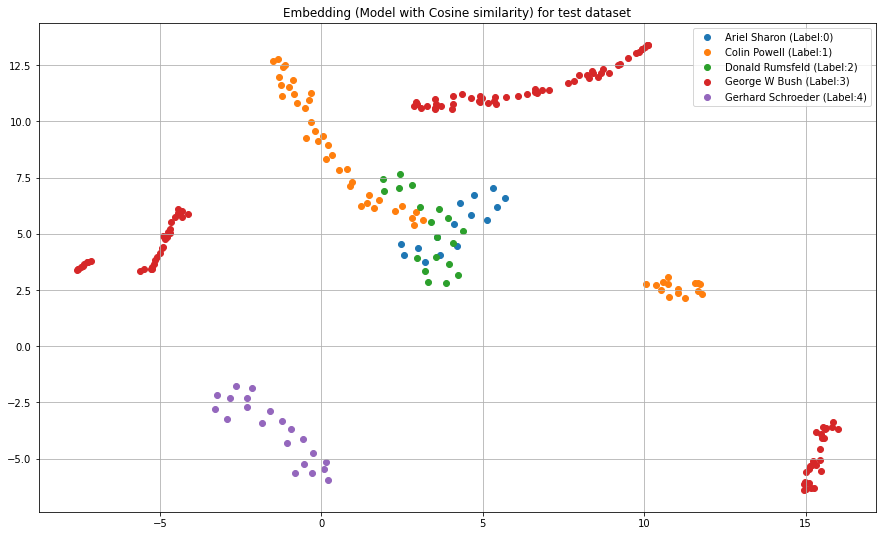

In [ ]:
plt.gcf().set_size_inches(15,9,forward=True)
plt.scatter(reduce_embedding_Class_0[:,0],reduce_embedding_Class_0[:,1])
plt.scatter(reduce_embedding_Class_1[:,0],reduce_embedding_Class_1[:,1])
plt.scatter(reduce_embedding_Class_2[:,0],reduce_embedding_Class_2[:,1])
plt.scatter(reduce_embedding_Class_3[:,0],reduce_embedding_Class_3[:,1])
plt.scatter(reduce_embedding_Class_4[:,0],reduce_embedding_Class_4[:,1])
plt.grid()
plt.legend([lfw_subset.target_names[0]+' (Label:0)',lfw_subset.target_names[1]+' (Label:1)',lfw_subset.target_names[2]+' (Label:2)',lfw_subset.target_names[3]+' (Label:3)',lfw_subset.target_names[4]+' (Label:4)'])
plt.title('Embedding (Model with Cosine similarity) for test dataset')
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/cosine_embedding_test.jpg')
plt.show()

### KNN Classifier (Model with Cosine Similarity):

#### Train dataset:

In [ ]:
embedding_train = np.zeros((len(X_train_n),100))
for i in range(len(X_train_n)):
  embedding_train[i,:] = model(X_train_n[i,:].reshape(1,250,250,3))

knn_train = KNeighborsClassifier(n_neighbors=1) # metric is euclidean distance
knn_train.fit(embedding_train, y_train)
Acc_train = knn_train.score(embedding_train, y_train)
print("Accuracy for train dataset is:  ",Acc_train)

Accuracy for train dataset is:   1.0


#### Test dataset:

In [ ]:
embedding_test = model(X_test_n)
Acc_test = knn_train.score(embedding_test, y_test)
print("Accuracy for test dataset is:  ",Acc_test)

Accuracy for test dataset is:   0.7745901639344263


### Considering loss(with euclidean distance), optimiser and learning rate:

In [ ]:
model = Model_generator(input_shape = (250, 250, 3))
#Defining Loss
distance = 'L2' #@param ["cosine", "L2", "L1"]{allow-input: false}
Loss = TripletLoss(distance=distance)

opt = Adam(learning_rate=0.00002)
model.compile(optimizer=opt, loss=Loss)
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Distance metric automatically set to euclidean use the distance arg to override.
Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputTensor (InputLayer)    [(None, 250, 250, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flat (Flatten)              (None, 131072)            0         
                                                                 
 Fully_Connected (Dense)     (None, 100)               13107300  
                                                                 
Total params: 36,695,012
Trainable params: 36,641,892
Non-trainable params: 53,120
_________________________________________________________________


Train model with euclidean distance base triplet loss :

In [ ]:
EPOCHS = 15
best_save=ModelCheckpoint('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model',save_best_only=True,monitor='loss',mode='min')
start = time.time()
history = model.fit(train_sampler, epochs=EPOCHS, validation_data=(X_test_n, y_test),callbacks=[best_save])
stop = time.time()
train_time = stop-start
print('training time is :'  ,train_time)

Epoch 1/15
1000/1000 [==============================] - ETA: 0s - loss: 0.0252

1000/1000 [==============================] - 1243s 1s/step - loss: 0.0252 - val_loss: 0.8371
Warmup complete
Epoch 2/15
1000/1000 [==============================] - ETA: 0s - loss: 7.3607e-04

1000/1000 [==============================] - 1215s 1s/step - loss: 7.3607e-04 - val_loss: 0.0147
Epoch 3/15
1000/1000 [==============================] - ETA: 0s - loss: 1.3119e-05

1000/1000 [==============================] - 1212s 1s/step - loss: 1.3119e-05 - val_loss: 0.0046
Epoch 4/15
1000/1000 [==============================] - ETA: 0s - loss: 0.0000e+00

1000/1000 [==============================] - 1210s 1s/step - loss: 0.0000e+00 - val_loss: 0.0055
Epoch 5/15
1000/1000 [==============================] - 1189s 1s/step - loss: 5.7039e-04 - val_loss: 2.4327e-04
Epoch 6/15
1000/1000 [==============================] - 1186s 1s/step - loss: 1.2001e-04 - val_loss: 0.0073
Epoch 7/15
1000/1000 [==============================] - 1185s 1s/step - loss: 0.0000e+00 - val_loss: 0.0063
Epoch 8/15
1000/1000 [==============================] - 1182s 1s/step - loss: 0.0000e+00 - val_loss: 0.0055
Epoch 9/15
1000/1000 [==============================] - 1181s 1s/step - loss: 0.0000e+00 - val_loss: 0.0038
Epoch 10/15
1000/1000 [==============================] - 1181s 1s/step - loss: 0.0000e+00 - val_loss: 0.0078
Epoch 11/15
1000/1000 [==============================] - 1183s 1s/step - loss: 2.7764e-04 - val_loss: 0.0000e+00
Epoch 12/15
1000/1000 [==============================] - 1181s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/15
1000/1000 [=

Plot loss during the training:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


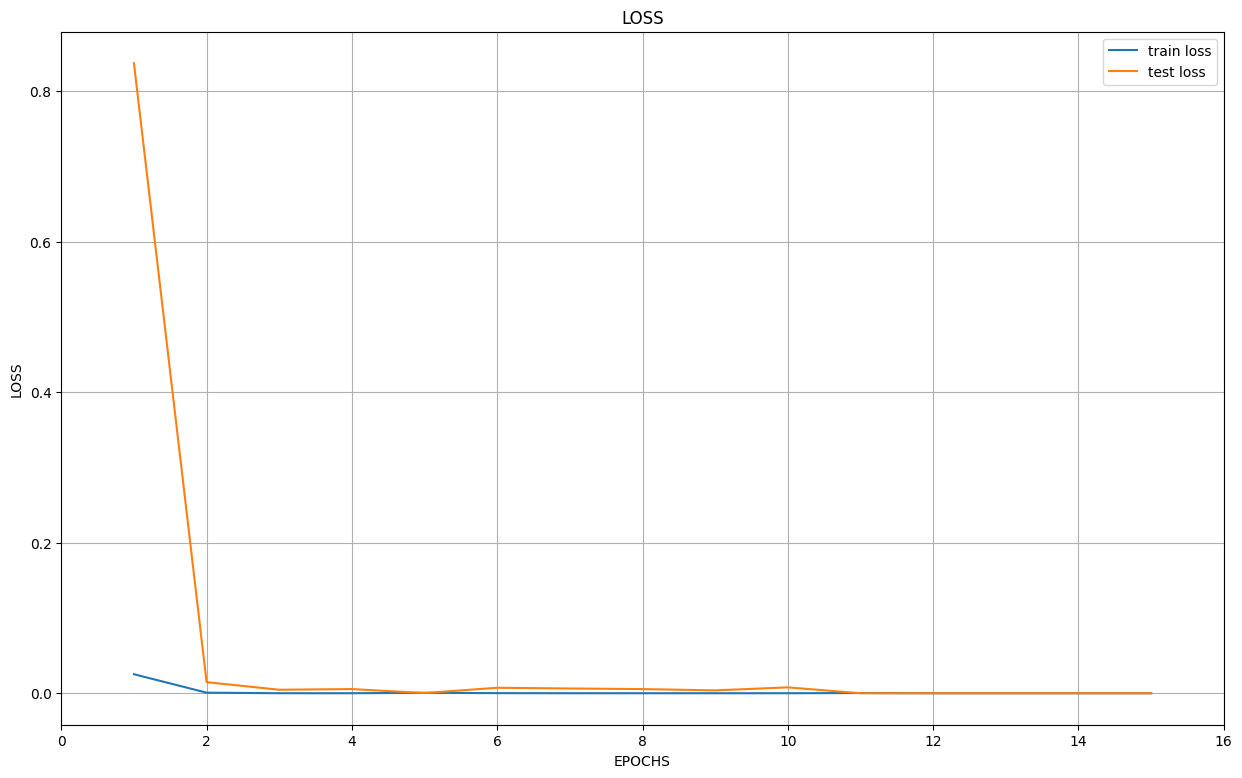

In [ ]:
drive.mount('/content/drive')
import matplotlib
matplotlib.style.use('default')
loss=history.history['loss']
val_loss=history.history['val_loss']

EPOCH= range(1,EPOCHS + 1)

plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,loss)
plt.plot(EPOCH,val_loss)
plt.title('LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.grid()
plt.xlim([0,EPOCHS + 1])
plt.legend(['train loss','test loss'])
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/euclidean_Loss.jpg')
plt.show()

#### Embedding (Model with Euclidean Distance) for training dataset:

Load model:

In [ ]:
drive.mount('/content/drive')
model.load_weights('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ploting embedding:

In [ ]:
NClass_Mem = np.zeros(5,dtype='int') # an array to save number of every classe in the train dataset
for i in range(len(y_train)):
  if y_train[i]==0 :
    NClass_Mem[0]=NClass_Mem[0]+1
  if y_train[i]==1 :
    NClass_Mem[1]=NClass_Mem[1]+1
  if y_train[i]==2 :
    NClass_Mem[2]=NClass_Mem[2]+1
  if y_train[i]==3 :
    NClass_Mem[3]=NClass_Mem[3]+1
  if y_train[i]==4 :
    NClass_Mem[4]=NClass_Mem[4]+1

Class_0 = np.zeros((NClass_Mem[0],250,250,3))
Class_1 = np.zeros((NClass_Mem[1],250,250,3))
Class_2 = np.zeros((NClass_Mem[2],250,250,3))
Class_3 = np.zeros((NClass_Mem[3],250,250,3))
Class_4 = np.zeros((NClass_Mem[4],250,250,3))

Class_conter = np.zeros(5,dtype='int') 
for i in range(len(y_train)):
  if y_train[i]==0 :
    Class_0[Class_conter[0],:] =X_train_n[i,:] 
    Class_conter[0]=Class_conter[0]+1
  if y_train[i]==1 :
    Class_1[Class_conter[1],:] =X_train_n[i,:] 
    Class_conter[1]=Class_conter[1]+1
  if y_train[i]==2 :
    Class_2[Class_conter[2],:] =X_train_n[i,:] 
    Class_conter[2]=Class_conter[2]+1
  if y_train[i]==3 :
    Class_3[Class_conter[3],:] =X_train_n[i,:] 
    Class_conter[3]=Class_conter[3]+1
  if y_train[i]==4 :
    Class_4[Class_conter[4],:] =X_train_n[i,:] 
    Class_conter[4]=Class_conter[4]+1

Emb_Class_0 = model(Class_0)
Emb_Class_1 = model(Class_1)
Emb_Class_2 = model(Class_2)
Emb_Class_3 = model(Class_3)
Emb_Class_4 = model(Class_4)

In [ ]:
reducer = umap.UMAP(random_state=0)
reduce_embedding_Class_0 = reducer.fit_transform(Emb_Class_0)
reduce_embedding_Class_1 = reducer.fit_transform(Emb_Class_1)
reduce_embedding_Class_2 = reducer.fit_transform(Emb_Class_2)
reduce_embedding_Class_3 = reducer.fit_transform(Emb_Class_3)
reduce_embedding_Class_4 = reducer.fit_transform(Emb_Class_4)

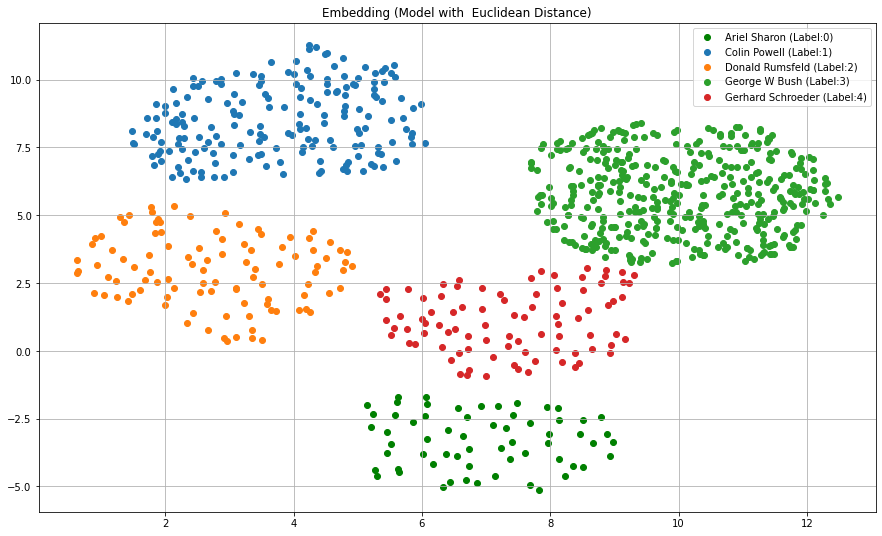

In [ ]:
plt.gcf().set_size_inches(15,9,forward=True)
plt.scatter(reduce_embedding_Class_0[:,0],reduce_embedding_Class_0[:,1],color="g")
plt.scatter(reduce_embedding_Class_1[:,0],reduce_embedding_Class_1[:,1])
plt.scatter(reduce_embedding_Class_2[:,0],reduce_embedding_Class_2[:,1])
plt.scatter(reduce_embedding_Class_3[:,0],reduce_embedding_Class_3[:,1])
plt.scatter(reduce_embedding_Class_4[:,0],reduce_embedding_Class_4[:,1])
plt.grid()
plt.legend([lfw_subset.target_names[0]+' (Label:0)',lfw_subset.target_names[1]+' (Label:1)',lfw_subset.target_names[2]+' (Label:2)',lfw_subset.target_names[3]+' (Label:3)',lfw_subset.target_names[4]+' (Label:4)'])
plt.title('Embedding (Model with Euclidean Distance)')
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/euclidean_embedding_train.jpg')
plt.show()

#### Embedding (Model with Euclidean Distance) for test dataset:

Ploting embedding:

In [ ]:
NClass_Mem = np.zeros(5,dtype='int') # an array to save number of every classe in the train dataset
for i in range(len(y_test)):
  if y_test[i]==0 :
    NClass_Mem[0]=NClass_Mem[0]+1
  if y_test[i]==1 :
    NClass_Mem[1]=NClass_Mem[1]+1
  if y_test[i]==2 :
    NClass_Mem[2]=NClass_Mem[2]+1
  if y_test[i]==3 :
    NClass_Mem[3]=NClass_Mem[3]+1
  if y_test[i]==4 :
    NClass_Mem[4]=NClass_Mem[4]+1

Class_0 = np.zeros((NClass_Mem[0],250,250,3))
Class_1 = np.zeros((NClass_Mem[1],250,250,3))
Class_2 = np.zeros((NClass_Mem[2],250,250,3))
Class_3 = np.zeros((NClass_Mem[3],250,250,3))
Class_4 = np.zeros((NClass_Mem[4],250,250,3))

Class_conter = np.zeros(5,dtype='int') 
for i in range(len(y_test)):
  if y_test[i]==0 :
    Class_0[Class_conter[0],:] =X_test_n[i,:] 
    Class_conter[0]=Class_conter[0]+1
  if y_test[i]==1 :
    Class_1[Class_conter[1],:] =X_test_n[i,:] 
    Class_conter[1]=Class_conter[1]+1
  if y_test[i]==2 :
    Class_2[Class_conter[2],:] =X_test_n[i,:] 
    Class_conter[2]=Class_conter[2]+1
  if y_test[i]==3 :
    Class_3[Class_conter[3],:] =X_test_n[i,:] 
    Class_conter[3]=Class_conter[3]+1
  if y_test[i]==4 :
    Class_4[Class_conter[4],:] =X_test_n[i,:] 
    Class_conter[4]=Class_conter[4]+1

Emb_Class_0 = model(Class_0)
Emb_Class_1 = model(Class_1)
Emb_Class_2 = model(Class_2)
Emb_Class_3 = model(Class_3)
Emb_Class_4 = model(Class_4)

In [ ]:
reducer = umap.UMAP(random_state=0)
reduce_embedding_Class_0 = reducer.fit_transform(Emb_Class_0)
reduce_embedding_Class_1 = reducer.fit_transform(Emb_Class_1)
reduce_embedding_Class_2 = reducer.fit_transform(Emb_Class_2)
reduce_embedding_Class_3 = reducer.fit_transform(Emb_Class_3)
reduce_embedding_Class_4 = reducer.fit_transform(Emb_Class_4)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


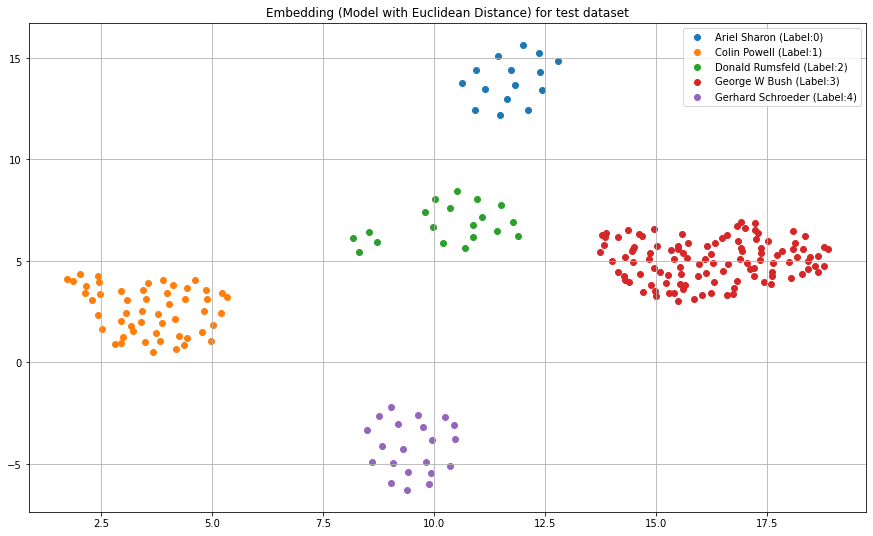

In [ ]:
plt.gcf().set_size_inches(15,9,forward=True)
plt.scatter(reduce_embedding_Class_0[:,0],reduce_embedding_Class_0[:,1])
plt.scatter(reduce_embedding_Class_1[:,0],reduce_embedding_Class_1[:,1])
plt.scatter(reduce_embedding_Class_2[:,0],reduce_embedding_Class_2[:,1])
plt.scatter(reduce_embedding_Class_3[:,0],reduce_embedding_Class_3[:,1])
plt.scatter(reduce_embedding_Class_4[:,0],reduce_embedding_Class_4[:,1])
plt.grid()
plt.legend([lfw_subset.target_names[0]+' (Label:0)',lfw_subset.target_names[1]+' (Label:1)',lfw_subset.target_names[2]+' (Label:2)',lfw_subset.target_names[3]+' (Label:3)',lfw_subset.target_names[4]+' (Label:4)'])
plt.title('Embedding (Model with Euclidean Distance) for test dataset')
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/euclidean_embedding_test.jpg')
plt.show()

### KNN Classifier (Model with Euclidean Distance):

#### Train dataset:

In [ ]:
embedding_train = np.zeros((len(X_train_n),100))
for i in range(len(X_train_n)):
  embedding_train[i,:] = model(X_train_n[i,:].reshape(1,250,250,3))

knn_train = KNeighborsClassifier(n_neighbors=1) # metric is euclidean distance
knn_train.fit(embedding_train, y_train)
Acc_train = knn_train.score(embedding_train, y_train)
print("Accuracy for train dataset is:  ",Acc_train)

Accuracy for train dataset is:   1.0


#### Test dataset:

In [ ]:
embedding_test = model(X_test_n)
Acc_test = knn_train.score(embedding_test, y_test)
print("Accuracy for test dataset is:  ",Acc_test)

Accuracy for test dataset is:   0.9877049180327869


## Train with example mining:

According to the previous result the distance cosidered euclidean 

First strategy is semi-hard-negative , hard-positive

In [ ]:
model = Model_generator(input_shape = (250, 250, 3))
#Defining Loss
distance = 'L2'
Loss = TripletLoss(distance=distance,positive_mining_strategy="hard",negative_mining_strategy="semi-hard")

opt = Adam(learning_rate=0.00002)
model.compile(optimizer=opt, loss=Loss)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Distance metric automatically set to euclidean use the distance arg to override.
Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputTensor (InputLayer)    [(None, 250, 250, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flat (Flatten)              (None, 131072)            0         
                                                                 
 Fully_Connected (Dense)     (None, 100)               13107300  
                                                                 
Total params: 36,695,012
Trainable params: 36,641,892
Non-trainable params: 53,120
_________________________________________________________________


Train 5 epochs with semi-hard-negative , hard-positive strategy:

In [ ]:
EPOCHS = 5
best_save=ModelCheckpoint('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining',save_best_only=True,monitor='loss',mode='min')
start = time.time()
history_1 = model.fit(train_sampler, epochs=EPOCHS, validation_data=(X_test_n, y_test),callbacks=[best_save])
stop = time.time()
train_time = stop-start
print('phase one training time is :'  ,train_time)

Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0262

1000/1000 [==============================] - 1251s 1s/step - loss: 0.0262 - val_loss: 0.8118
Warmup complete
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 7.7022e-04

1000/1000 [==============================] - 1227s 1s/step - loss: 7.7022e-04 - val_loss: 0.0207
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 1.4647e-04

1000/1000 [==============================] - 1223s 1s/step - loss: 1.4647e-04 - val_loss: 0.0033
Epoch 4/5
1000/1000 [==============================] - 1203s 1s/step - loss: 2.9161e-04 - val_loss: 0.0022
Epoch 5/5
1000/1000 [==============================] - ETA: 0s - loss: 2.4674e-05

1000/1000 [==============================] - 1222s 1s/step - loss: 2.4674e-05 - val_loss: 0.0000e+00
phase one training time is : 6162.887893915176


Save Losses:

In [ ]:
drive.mount('/content/drive')
np.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/loss_1.npy',history_1.history['loss'])
np.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/val_loss_1.npy',history_1.history['val_loss'])
model.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/Mining')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch strategy to the hard-negative , hard-positive and train another 10 epoches:

In [ ]:
distance = 'L2'
Loss = TripletLoss(distance=distance,positive_mining_strategy="hard",negative_mining_strategy="hard")
model.compile(optimizer=opt, loss=Loss)

Distance metric automatically set to euclidean use the distance arg to override.


Load model:

In [ ]:
drive.mount('/content/drive')
model.load_weights('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EPOCHS = 10
best_save=ModelCheckpoint('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/Mining',save_best_only=True,monitor='loss',mode='min')
start = time.time()
history_2 = model.fit(train_sampler, epochs=EPOCHS, validation_data=(X_test_n, y_test),callbacks=[best_save])
stop = time.time()
train_time = stop-start
print('phase two training time is :'  ,train_time)

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.0191

1000/1000 [==============================] - 1264s 1s/step - loss: 0.0191 - val_loss: 0.1112
Warmup complete
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 9.1441e-06

1000/1000 [==============================] - 1240s 1s/step - loss: 9.1441e-06 - val_loss: 0.0000e+00
Epoch 3/10
1000/1000 [==============================] - 1215s 1s/step - loss: 9.3027e-04 - val_loss: 0.0000e+00
Epoch 4/10
1000/1000 [==============================] - ETA: 0s - loss: 0.0000e+00

1000/1000 [==============================] - 1232s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
 423/1000 [===========>..................] - ETA: 11:37 - loss: 0.0000e+00

In [ ]:
drive.mount('/content/drive')
np.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/loss_2.npy',history_2.history['loss'])
np.save('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/val_loss_2.npy',history_2.history['val_loss'])

Plot loss during the training:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

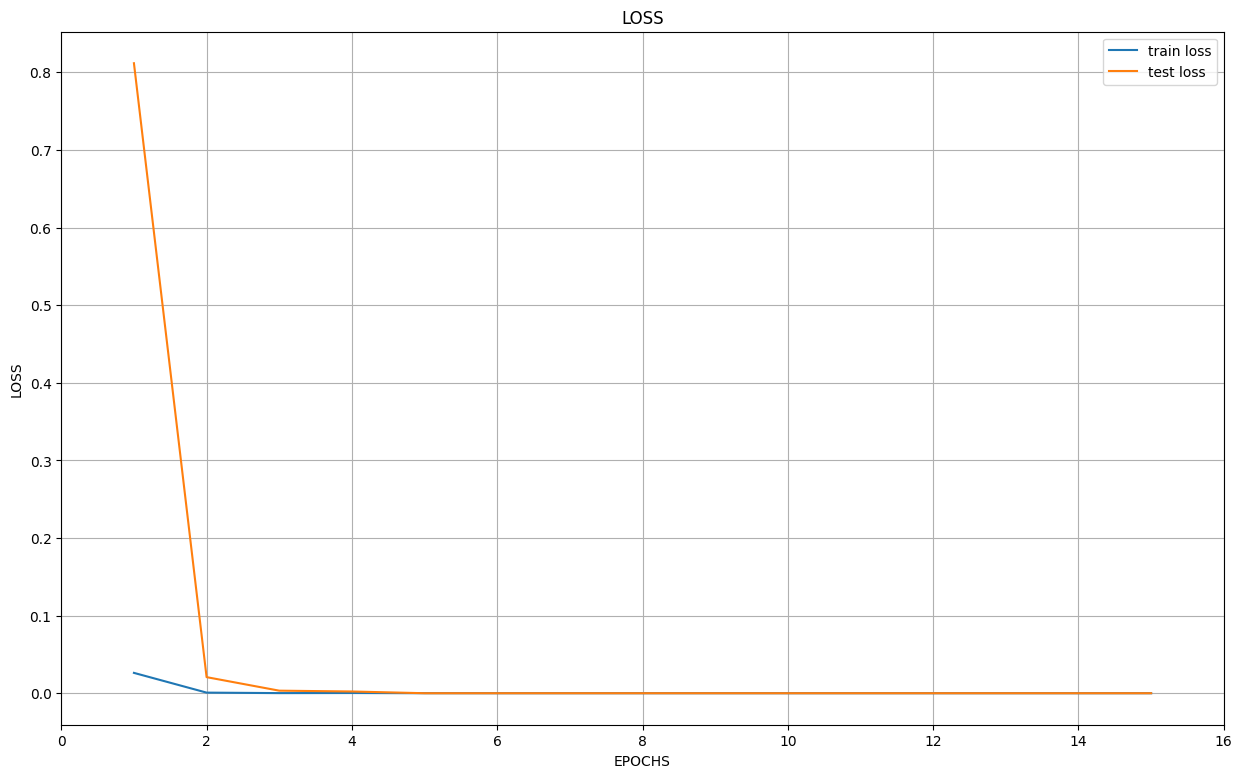

In [ ]:
drive.mount('/content/drive')
import matplotlib
loss = np.zeros(15)
val_loss= np.zeros(15)
matplotlib.style.use('default')
loss[:5]=np.load('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/loss_1.npy')
val_loss[:5] = np.load('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/val_loss_1.npy')
loss[5:]=np.load('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/loss_2.npy')
val_loss[5:] = np.load('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/mining'+'/val_loss_2.npy')


EPOCH= range(1,15 + 1)

plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,loss)
plt.plot(EPOCH,val_loss)
plt.title('LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.grid()
plt.xlim([0,15 + 1])
plt.legend(['train loss','test loss'])
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/mining_Loss.jpg')
plt.show()

#### Embedding (Model with Example Mining and Euclidean Distance) for training dataset:

Load model:

In [ ]:
drive.mount('/content/drive')
model.load_weights('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Model/example')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NClass_Mem = np.zeros(5,dtype='int') # an array to save number of every classe in the train dataset
for i in range(len(y_train)):
  if y_train[i]==0 :
    NClass_Mem[0]=NClass_Mem[0]+1
  if y_train[i]==1 :
    NClass_Mem[1]=NClass_Mem[1]+1
  if y_train[i]==2 :
    NClass_Mem[2]=NClass_Mem[2]+1
  if y_train[i]==3 :
    NClass_Mem[3]=NClass_Mem[3]+1
  if y_train[i]==4 :
    NClass_Mem[4]=NClass_Mem[4]+1

Class_0 = np.zeros((NClass_Mem[0],250,250,3))
Class_1 = np.zeros((NClass_Mem[1],250,250,3))
Class_2 = np.zeros((NClass_Mem[2],250,250,3))
Class_3 = np.zeros((NClass_Mem[3],250,250,3))
Class_4 = np.zeros((NClass_Mem[4],250,250,3))

Class_conter = np.zeros(5,dtype='int') 
for i in range(len(y_train)):
  if y_train[i]==0 :
    Class_0[Class_conter[0],:] =X_train_n[i,:] 
    Class_conter[0]=Class_conter[0]+1
  if y_train[i]==1 :
    Class_1[Class_conter[1],:] =X_train_n[i,:] 
    Class_conter[1]=Class_conter[1]+1
  if y_train[i]==2 :
    Class_2[Class_conter[2],:] =X_train_n[i,:] 
    Class_conter[2]=Class_conter[2]+1
  if y_train[i]==3 :
    Class_3[Class_conter[3],:] =X_train_n[i,:] 
    Class_conter[3]=Class_conter[3]+1
  if y_train[i]==4 :
    Class_4[Class_conter[4],:] =X_train_n[i,:] 
    Class_conter[4]=Class_conter[4]+1

Emb_Class_0 = model(Class_0)
Emb_Class_1 = model(Class_1)
Emb_Class_2 = model(Class_2)
Emb_Class_3 = model(Class_3)
Emb_Class_4 = model(Class_4)

In [ ]:
reducer = umap.UMAP()
reduce_embedding_Class_0 = reducer.fit_transform(Emb_Class_0)
reduce_embedding_Class_1 = reducer.fit_transform(Emb_Class_1)
reduce_embedding_Class_2 = reducer.fit_transform(Emb_Class_2)
reduce_embedding_Class_3 = reducer.fit_transform(Emb_Class_3)
reduce_embedding_Class_4 = reducer.fit_transform(Emb_Class_4)

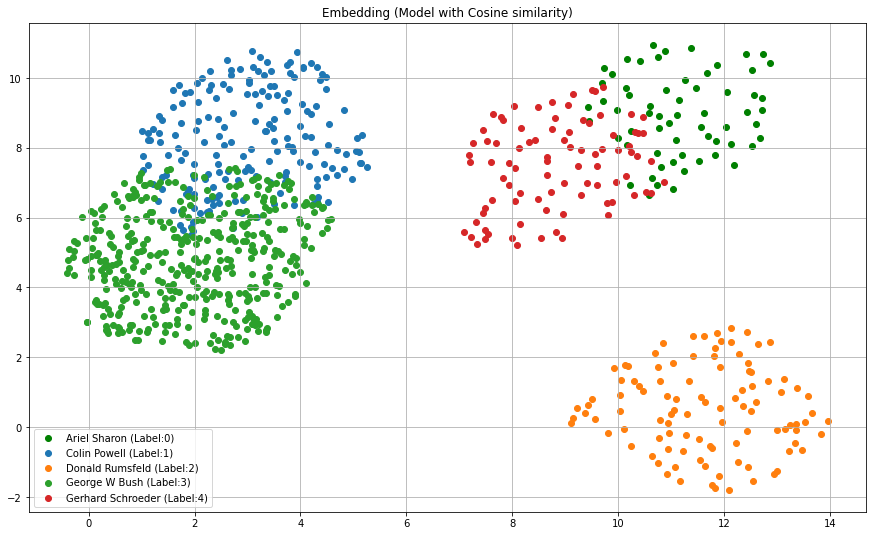

In [ ]:
plt.gcf().set_size_inches(15,9,forward=True)
plt.scatter(reduce_embedding_Class_0[:,0],reduce_embedding_Class_0[:,1],color="g")
plt.scatter(reduce_embedding_Class_1[:,0],reduce_embedding_Class_1[:,1])
plt.scatter(reduce_embedding_Class_2[:,0],reduce_embedding_Class_2[:,1])
plt.scatter(reduce_embedding_Class_3[:,0],reduce_embedding_Class_3[:,1])
plt.scatter(reduce_embedding_Class_4[:,0],reduce_embedding_Class_4[:,1])
plt.grid()
plt.legend([lfw_subset.target_names[0]+' (Label:0)',lfw_subset.target_names[1]+' (Label:1)',lfw_subset.target_names[2]+' (Label:2)',lfw_subset.target_names[3]+' (Label:3)',lfw_subset.target_names[4]+' (Label:4)'])
plt.title('Embedding (Model with Example Mining and Euclidean Distance)')
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/euclidean_embedding_train.jpg')
plt.show()

#### Embedding (Model with Example Mining and Euclidean Distance) for test dataset:

Ploting embedding:

In [ ]:
NClass_Mem = np.zeros(5,dtype='int') # an array to save number of every classe in the train dataset
for i in range(len(y_test)):
  if y_test[i]==0 :
    NClass_Mem[0]=NClass_Mem[0]+1
  if y_test[i]==1 :
    NClass_Mem[1]=NClass_Mem[1]+1
  if y_test[i]==2 :
    NClass_Mem[2]=NClass_Mem[2]+1
  if y_test[i]==3 :
    NClass_Mem[3]=NClass_Mem[3]+1
  if y_test[i]==4 :
    NClass_Mem[4]=NClass_Mem[4]+1

Class_0 = np.zeros((NClass_Mem[0],250,250,3))
Class_1 = np.zeros((NClass_Mem[1],250,250,3))
Class_2 = np.zeros((NClass_Mem[2],250,250,3))
Class_3 = np.zeros((NClass_Mem[3],250,250,3))
Class_4 = np.zeros((NClass_Mem[4],250,250,3))

Class_conter = np.zeros(5,dtype='int') 
for i in range(len(y_test)):
  if y_test[i]==0 :
    Class_0[Class_conter[0],:] =X_test_n[i,:] 
    Class_conter[0]=Class_conter[0]+1
  if y_test[i]==1 :
    Class_1[Class_conter[1],:] =X_test_n[i,:] 
    Class_conter[1]=Class_conter[1]+1
  if y_test[i]==2 :
    Class_2[Class_conter[2],:] =X_test_n[i,:] 
    Class_conter[2]=Class_conter[2]+1
  if y_test[i]==3 :
    Class_3[Class_conter[3],:] =X_test_n[i,:] 
    Class_conter[3]=Class_conter[3]+1
  if y_test[i]==4 :
    Class_4[Class_conter[4],:] =X_test_n[i,:] 
    Class_conter[4]=Class_conter[4]+1

Emb_Class_0 = model(Class_0)
Emb_Class_1 = model(Class_1)
Emb_Class_2 = model(Class_2)
Emb_Class_3 = model(Class_3)
Emb_Class_4 = model(Class_4)

In [ ]:
reducer = umap.UMAP()
reduce_embedding_Class_0 = reducer.fit_transform(Emb_Class_0)
reduce_embedding_Class_1 = reducer.fit_transform(Emb_Class_1)
reduce_embedding_Class_2 = reducer.fit_transform(Emb_Class_2)
reduce_embedding_Class_3 = reducer.fit_transform(Emb_Class_3)
reduce_embedding_Class_4 = reducer.fit_transform(Emb_Class_4)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


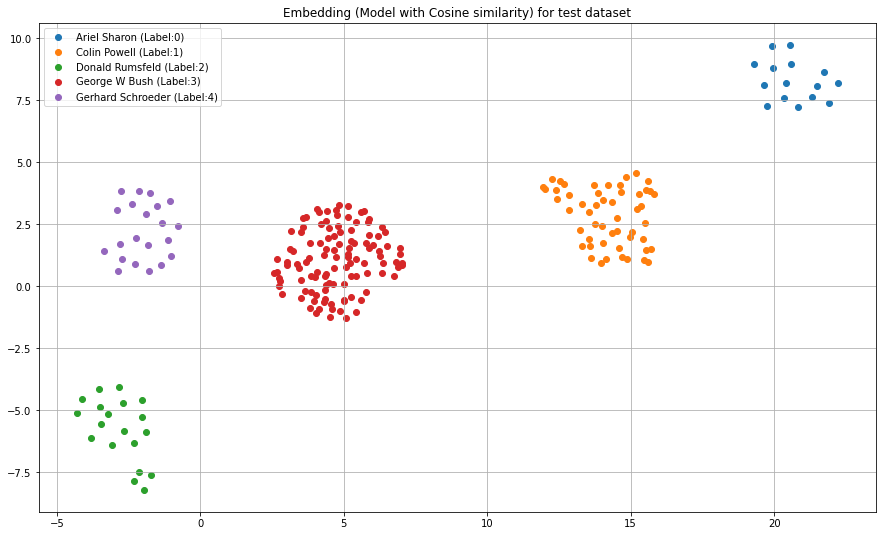

In [ ]:
plt.gcf().set_size_inches(15,9,forward=True)
plt.scatter(reduce_embedding_Class_0[:,0],reduce_embedding_Class_0[:,1])
plt.scatter(reduce_embedding_Class_1[:,0],reduce_embedding_Class_1[:,1])
plt.scatter(reduce_embedding_Class_2[:,0],reduce_embedding_Class_2[:,1])
plt.scatter(reduce_embedding_Class_3[:,0],reduce_embedding_Class_3[:,1])
plt.scatter(reduce_embedding_Class_4[:,0],reduce_embedding_Class_4[:,1])
plt.grid()
plt.legend([lfw_subset.target_names[0]+' (Label:0)',lfw_subset.target_names[1]+' (Label:1)',lfw_subset.target_names[2]+' (Label:2)',lfw_subset.target_names[3]+' (Label:3)',lfw_subset.target_names[4]+' (Label:4)'])
plt.title('Embedding (Model with Example Mining and Euclidean Distance) for test dataset')
plt.savefig('/content/drive/MyDrive/Design and Analysis of Deep Neural Networks/HW2/Pic/euclidean_embedding_test.jpg')
plt.show()

### KNN Classifier (Model with Example Mining and Euclidean Distance):

In [ ]:
embedding_train = np.zeros((len(X_train_n),100))
for i in range(len(X_train_n)):
  embedding_train[i,:] = model(X_train_n[i,:].reshape(1,250,250,3))

knn_train = KNeighborsClassifier(n_neighbors=1) # metric is euclidean distance
knn_train.fit(embedding_train, y_train)
Acc_train = knn_train.score(embedding_train, y_train)
print("Accuracy for train dataset is:  ",Acc_train)

Accuracy for train dataset is:   1.0


#### Test dataset:

In [ ]:
embedding_test = model(X_test_n)
knn_test = KNeighborsClassifier(n_neighbors=1) # metric is euclidean distance
knn_test.fit(embedding_test, y_test)
Acc_test = knn_test.score(embedding_test, y_test)
print("Accuracy for test dataset is:  ",Acc_test)

Accuracy for test dataset is:   1.0
